In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2024/players.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv
/kaggle/input/nfl-big-data-bowl-2024/games.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv
/kaggle/input/nfl-big-data-bowl-2024/tackles.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv
/kaggle/input/nfl-big-data-bowl-2024/plays.csv
/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv


# Initial Exploration

I want to start by investigating the general structure of the provided play data. The next section will assess:
- The number of observed plays in weeks 1-9
- Columns containing missing data and whether they are potential features that should be dealt with
- Bivariate relationships between data

## Creating Full Dataset

In [2]:
plays_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
week1 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_1.csv')
week2 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_2.csv')
week3 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_3.csv')
week4 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_4.csv')
week5 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_5.csv')
week6 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_6.csv')
week7 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_7.csv')
week8 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_8.csv')
week9 = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tracking_week_9.csv')
full_season = pd.concat([week1,week2,week3,week4,week5,week6,week7,week8,week9],ignore_index=True)

## Assessing instances of unique plays

In [3]:
fullSeason_plays = plays_df.merge(full_season,how='inner')

fullSeason_full_plays = fullSeason_plays.loc[fullSeason_plays['playNullifiedByPenalty'] == 'N',:]

events = ['tackle','out_of_bounds','touchdown','qb_sack','fumble_offense_recovered','fumble_defense_recovered']
fullSeason_unique_plays_idx = fullSeason_full_plays.loc[fullSeason_full_plays['event'].isin(events)].groupby(['gameId','playId']).head(1).index
fullSeason_unique_plays = fullSeason_full_plays.loc[fullSeason_unique_plays_idx].reset_index()

## Feature engineering

In [4]:
#Creating 'tackled_for_loss' variable
fullSeason_unique_plays.loc[:,'tackled_for_loss'] = 0
fullSeason_unique_plays.loc[fullSeason_unique_plays['prePenaltyPlayResult'] < 0,'tackled_for_loss'] = 1
fullSeason_unique_plays[['playNullifiedByPenalty','prePenaltyPlayResult','tackled_for_loss']].sort_values(by='tackled_for_loss',ascending=False)

#Creating 'gameClock_minutes' and `is_two_minutes' variables
fullSeason_unique_plays['gameClock_minutes'] = fullSeason_unique_plays['gameClock'].str.split(':',expand=True)[0].astype(float) + (fullSeason_unique_plays['gameClock'].str.split(':',expand=True)[1].astype(float)/60)
fullSeason_unique_plays['is_two_minutes'] = 0
fullSeason_unique_plays.loc[fullSeason_unique_plays['gameClock_minutes'] <= 2,'is_two_minutes'] = 1

#Creating 'end_of_half' variable
fullSeason_unique_plays['end_of_half'] = 0
fullSeason_unique_plays.loc[(fullSeason_unique_plays['is_two_minutes'] == 1) & (fullSeason_unique_plays['quarter'].isin([2,4])),'end_of_half'] = 1

#Creating `is_in_redzone` variable
fullSeason_unique_plays['is_in_redzone'] = 0
fullSeason_unique_plays.loc[fullSeason_unique_plays['absoluteYardlineNumber']<=20,'is_in_redzone'] = 1
fullSeason_unique_plays.shape

(11945, 56)

In [5]:
fullSeason_unique_plays.isna().sum()

index                                   0
gameId                                  0
playId                                  0
ballCarrierId                           0
ballCarrierDisplayName                  0
playDescription                         0
quarter                                 0
down                                    0
yardsToGo                               0
possessionTeam                          0
defensiveTeam                           0
yardlineSide                          161
yardlineNumber                          0
gameClock                               0
preSnapHomeScore                        0
preSnapVisitorScore                     0
passResult                           6166
passLength                           6522
penaltyYards                        11679
prePenaltyPlayResult                    0
playResult                              0
playNullifiedByPenalty                  0
absoluteYardlineNumber                  0
offenseFormation                  

## Exploratory Data Analysis

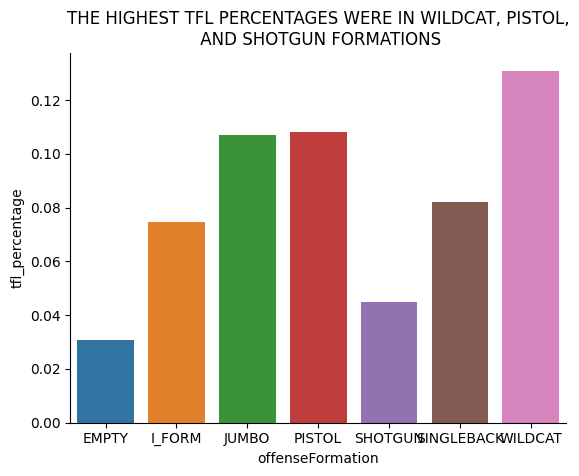

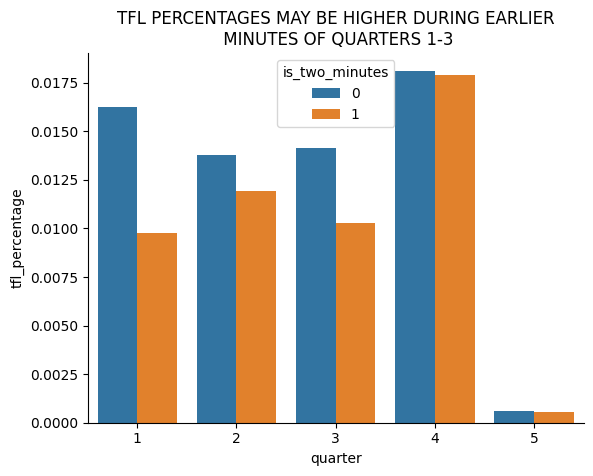

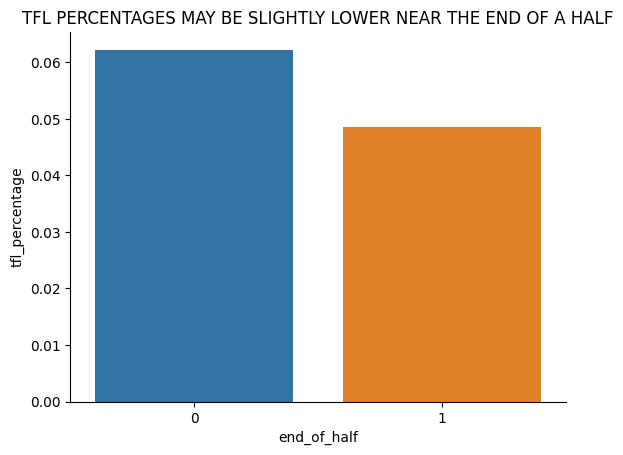

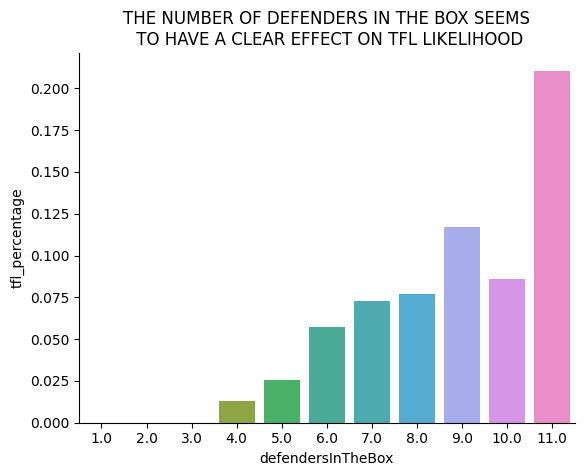

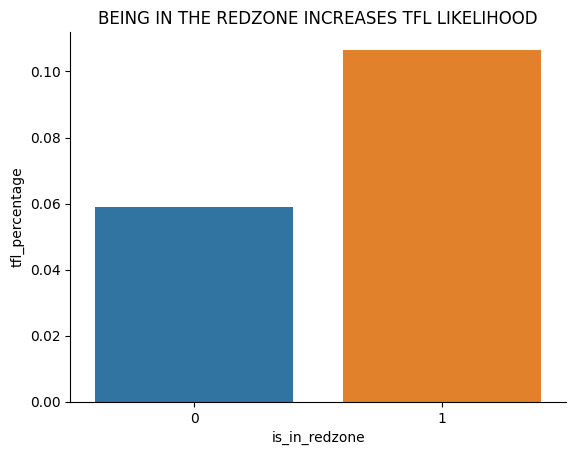

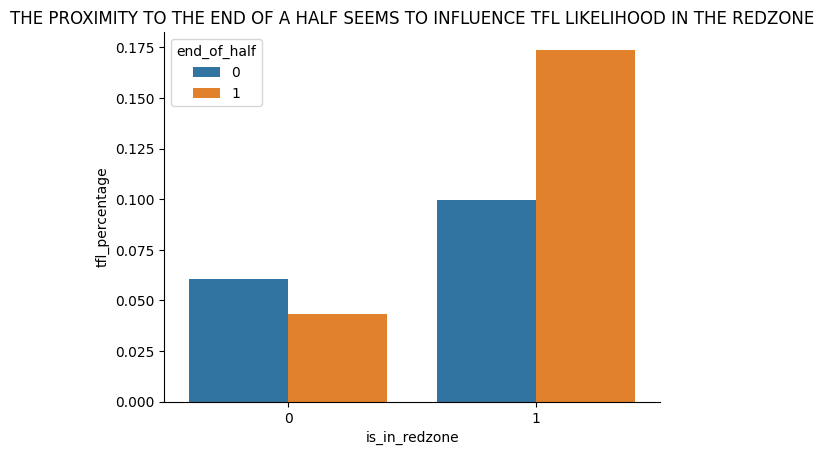

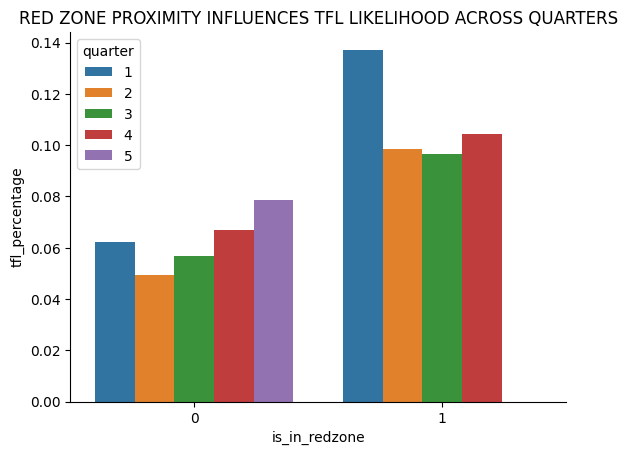

In [6]:
_df = fullSeason_unique_plays.groupby('offenseFormation',as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby('offenseFormation',as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='offenseFormation',y='tfl_percentage')
plt.title(f"THE HIGHEST TFL PERCENTAGES WERE IN WILDCAT, PISTOL,\n AND SHOTGUN FORMATIONS")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby(['is_two_minutes','quarter'],as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby('is_two_minutes',as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='quarter',y='tfl_percentage',hue='is_two_minutes')
plt.title(f"TFL PERCENTAGES MAY BE HIGHER DURING EARLIER\n MINUTES OF QUARTERS 1-3")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby('end_of_half',as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby('end_of_half',as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='end_of_half',y='tfl_percentage')
plt.title(f"TFL PERCENTAGES MAY BE SLIGHTLY LOWER NEAR THE END OF A HALF")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby('defendersInTheBox',as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby('defendersInTheBox',as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='defendersInTheBox',y='tfl_percentage')
plt.title(f"THE NUMBER OF DEFENDERS IN THE BOX SEEMS\n TO HAVE A CLEAR EFFECT ON TFL LIKELIHOOD")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby('is_in_redzone',as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby('is_in_redzone',as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='is_in_redzone',y='tfl_percentage')
plt.title(f"BEING IN THE REDZONE INCREASES TFL LIKELIHOOD")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby(['is_in_redzone','end_of_half'],as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby(['is_in_redzone','end_of_half'],as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='is_in_redzone',y='tfl_percentage',hue='end_of_half')
plt.title(f"THE PROXIMITY TO THE END OF A HALF SEEMS TO INFLUENCE TFL LIKELIHOOD IN THE REDZONE")
sns.despine()
plt.show()

_df = fullSeason_unique_plays.groupby(['is_in_redzone','quarter'],as_index=False)['tackled_for_loss'].sum()
_df.rename(columns={'tackled_for_loss':'sum'},inplace=True)
_df2 = fullSeason_unique_plays.groupby(['is_in_redzone','quarter'],as_index=False)['tackled_for_loss'].count()
_df2.rename(columns={'tackled_for_loss':'count'},inplace=True)
_df3 = _df.merge(_df2)
_df3['tfl_percentage'] = _df3['sum'] / _df3['count']
sns.barplot(_df3,x='is_in_redzone',y='tfl_percentage',hue='quarter')
plt.title(f"RED ZONE PROXIMITY INFLUENCES TFL LIKELIHOOD ACROSS QUARTERS")
sns.despine()
plt.show()

